In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import randint
import pandas as pd

df = pd.read_csv("../titanic/Titanic-Dataset.csv")

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [223]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [224]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [225]:
df['Age'] = df['Age'].fillna(df['Age'].median())

In [226]:
df['HasCabin'] = df['Cabin'].notna().astype(int)

In [227]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [228]:
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

In [229]:
df['Sex'] = df['Sex'].map({'male' : 0, 'female' : 1})

In [ ]:
df['Embarked'] = df['Embarked'].fillna('Missing')
df['EmbarkedCat'] = pd.factorize(df['Embarked'])[0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,FamilySize,IsAlone,EmbarkedCat
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,1,2,0,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,NaN,S,0,1,1,0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,S,1,1,1,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,NaN,S,0,4,0,0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,C,1,1,1,1


In [230]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
HasCabin         0
FamilySize       0
IsAlone          0
dtype: int64

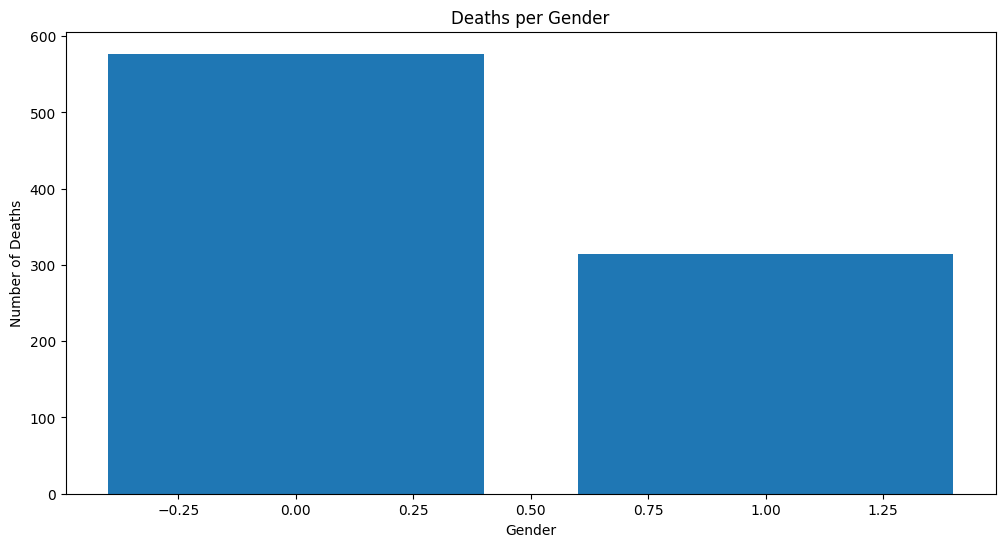

In [231]:
age_gender = df[['Survived', 'Sex']].groupby('Sex').count()

plt.figure(figsize=(12, 6))
plt.bar(age_gender.index, age_gender['Survived'])
plt.title('Deaths per Gender')
plt.ylabel('Number of Deaths')
plt.xlabel('Gender')
plt.show()



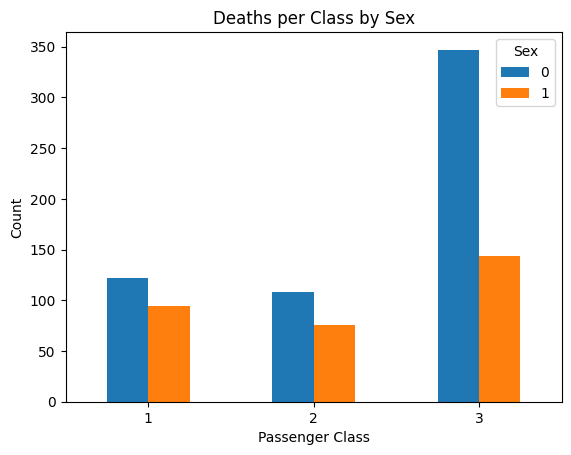

In [232]:
deaths_per_class = df[['Survived', 'Sex', 'Pclass']].groupby(['Pclass', 'Sex']).size().unstack(fill_value=0)
#plt.figure()
#plt.bar(deaths_per_class.index, deaths_per_class['Survived'])
#plt.show()
deaths_per_class.plot(kind='bar')
plt.title('Deaths per Class by Sex')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sex')
plt.show()

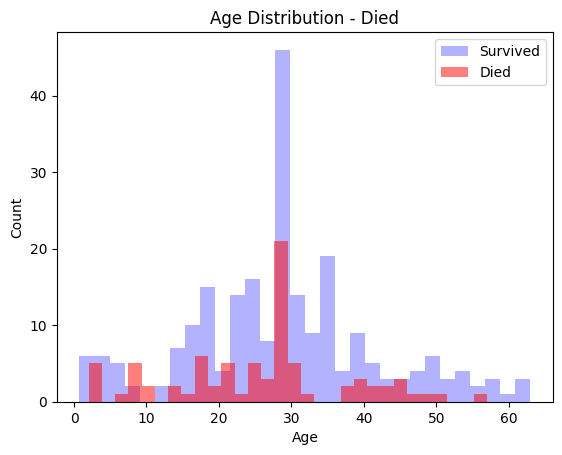

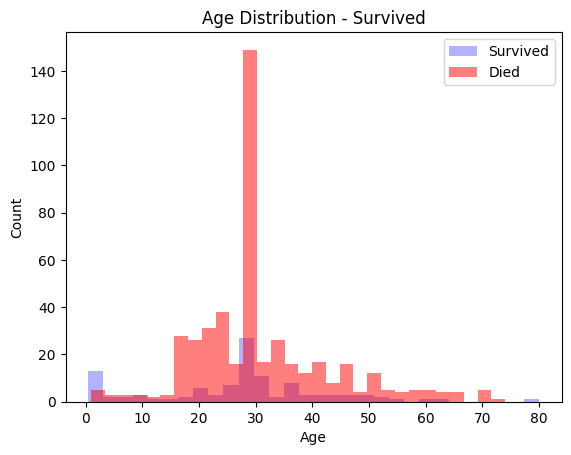

In [239]:
male = df[df['Sex'] == 1]
female = df[df['Sex'] == 0]

plt.figure()
plt.hist(male[male["Survived"] == 1]["Age"], bins=30, alpha=0.3, label="Survived", color='blue')
plt.hist(male[male["Survived"] == 0]["Age"], bins=30, alpha=0.5, label="Died", color='Red')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution - Died")
plt.legend()
plt.show()

plt.figure()
plt.hist(female[female["Survived"] == 1]["Age"], bins=30, alpha=0.3, label="Survived", color='blue')
plt.hist(female[female["Survived"] == 0]["Age"], bins=30, alpha=0.5, label="Died", color='Red')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution - Survived")
plt.legend()
plt.show()


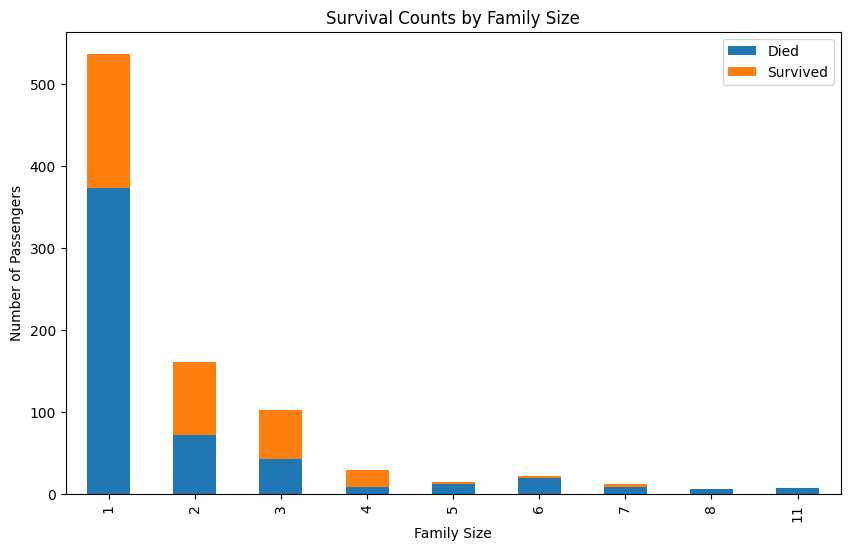

In [234]:
family_matters = pd.crosstab(df['FamilySize'], df['Survived'])

family_matters.plot(kind='bar', stacked=True, figsize=(10,6))

plt.xlabel("Family Size")
plt.ylabel("Number of Passengers")
plt.title("Survival Counts by Family Size")
plt.legend(["Died", "Survived"])
plt.show()


In [235]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,1,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,NaN,S,0,1,1
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,S,1,1,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,NaN,S,0,4,0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,C,1,1,1


In [243]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'HasCabin', 'FamilySize', 'IsAlone', 'EmbarkedCat']  

X = df[features]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [244]:
clf = RandomForestClassifier()

param_dist = {
    'n_estimators': randint(100, 1000),      # Number of trees
    'max_depth': randint(2, 20),             # Max depth of each tree
    'min_samples_split': randint(2, 20),     # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 20),      # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=50,          # Number of parameter settings sampled
    cv=5,               # 5-fold cross-validation
    scoring='accuracy', # Or another metric
    random_state=42,
    n_jobs=-1           # Use all cores
)

# Fit on training data
random_search.fit(X_train, y_train)

,estimator,RandomForestClassifier()
,param_distributions,"{'bootstrap': [True, False], 'max_depth': <scipy.stats....t 0x142837830>, 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': <scipy.stats....t 0x142834ec0>, ...}"
,n_iter,50
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [245]:
y_pred = random_search.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8100558659217877
